# 从零实现线性回归

## 学习目标

通过本notebook，你将学会：
- 理解线性回归的基本原理
- 从零实现线性回归算法（最小二乘法和梯度下降）
- 理解两种优化方法的区别和适用场景
- 掌握模型评估方法（MSE、R²）
- 可视化模型结果和训练过程

## 课程概述

本notebook将带你从零开始实现线性回归算法，包含两种优化方法：
1. **最小二乘法**：解析解，直接计算最优参数
2. **梯度下降**：数值解，迭代优化参数

我们将通过可视化和实验来理解这两种方法的区别。


## 1. 环境准备

### 版本要求
- Python >= 3.7
- NumPy >= 1.19.0
- Matplotlib >= 3.3.0
- scikit-learn >= 0.24.0

### 导入库


In [17]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 设置中文字体（如果需要显示中文）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置随机种子，确保结果可复现
np.random.seed(42)

# 设置matplotlib在notebook中内联显示
%matplotlib inline

print("环境准备完成！")
print(f"NumPy版本: {np.__version__}")


环境准备完成！
NumPy版本: 2.1.3


## 2. 理论回顾

### 线性回归的基本原理

线性回归试图找到一条直线（或超平面）来拟合数据，使得预测值与真实值之间的误差最小。

**数学形式**：
$$y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b$$

其中：
- $w_i$ 是权重（weight）
- $b$ 是偏置（bias）
- $x_i$ 是特征（feature）

### 两种优化方法

#### 方法1：最小二乘法（Least Squares）
- **原理**：直接求解解析解
- **公式**：$\theta = (X^T X)^{-1} X^T y$
- **优点**：计算快，一次求解
- **缺点**：需要计算矩阵逆，可能数值不稳定

#### 方法2：梯度下降（Gradient Descent）
- **原理**：迭代优化，沿着梯度方向更新参数
- **公式**：$\theta_{t+1} = \theta_t - \alpha \nabla J(\theta_t)$
- **优点**：适用于大规模数据，数值稳定
- **缺点**：需要迭代，可能收敛慢


## 3. 从零实现线性回归类

下面我们将从零实现一个线性回归类，支持两种优化方法。


In [18]:
class LinearRegression:
    """线性回归类（从零实现）"""
    
    def __init__(self, method='gradient_descent', learning_rate=0.01, 
                 max_iter=1000, tol=1e-6, random_state=42):
        """
        初始化线性回归模型
        
        参数:
        - method: 优化方法，'gradient_descent'（梯度下降）或 'least_squares'（最小二乘法）
        - learning_rate: 学习率（仅用于梯度下降），控制每次更新的步长
        - max_iter: 最大迭代次数（仅用于梯度下降），防止无限循环
        - tol: 收敛容差（仅用于梯度下降），当损失变化小于此值时停止
        - random_state: 随机种子，确保结果可复现
        """
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.w = None  # 权重参数
        self.b = None  # 偏置参数
        self.cost_history = []  # 记录损失函数的历史值（用于可视化）
    
    def _add_bias(self, X):
        """
        添加偏置项
        
        在特征矩阵前加一列1，这样可以将偏置b合并到权重w中
        例如：y = w*x + b 可以写成 y = [b, w] * [1, x]
        """
        m = X.shape[0]  # 样本数量
        return np.hstack([np.ones((m, 1)), X])  # 在X前面加一列全1
    
    def _least_squares(self, X, y):
        """
        最小二乘法（解析解）
        
        直接计算最优参数：theta = (X^T X)^(-1) X^T y
        这是线性回归的解析解，不需要迭代
        """
        # 添加偏置项
        X_bias = self._add_bias(X)
        
        # 计算 (X^T X)^(-1) X^T y
        try:
            # 使用伪逆提高数值稳定性
            # pinv是伪逆，即使矩阵不可逆也能计算
            theta = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y
        except np.linalg.LinAlgError:
            # 如果矩阵奇异（不可逆），直接使用伪逆
            theta = np.linalg.pinv(X_bias) @ y
        
        # 分离偏置和权重
        # theta[0]是偏置b，theta[1:]是权重w
        self.b = theta[0]
        self.w = theta[1:]
        
        return self
    
    def _gradient_descent(self, X, y):
        """
        梯度下降法（数值解）
        
        通过迭代更新参数，逐步逼近最优解
        每次迭代：theta = theta - learning_rate * gradient
        """
        m, n = X.shape  # m是样本数，n是特征数
        
        # 初始化参数（随机初始化权重，偏置初始化为0）
        np.random.seed(self.random_state)
        self.w = np.random.randn(n) * 0.01  # 权重初始化为小的随机值
        self.b = 0  # 偏置初始化为0
        
        # 梯度下降迭代
        for i in range(self.max_iter):
            # 1. 预测：使用当前参数计算预测值
            y_pred = X @ self.w + self.b  # 矩阵乘法：X @ w 表示 X * w
            
            # 2. 计算损失：均方误差（MSE）的一半
            # 除以2是为了求导方便，不影响最优解
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # 记录损失，用于可视化
            
            # 3. 计算梯度：损失函数对参数的导数
            # 对w的梯度：dw = (1/m) * X^T * (y_pred - y)
            dw = (1 / m) * X.T @ (y_pred - y)
            # 对b的梯度：db = (1/m) * sum(y_pred - y)
            db = (1 / m) * np.sum(y_pred - y)
            
            # 4. 更新参数：沿着梯度反方向更新（梯度下降）
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db
            
            # 5. 检查收敛：如果损失变化很小，提前停止
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tol:
                print(f"在第 {i+1} 次迭代后收敛")
                break
        
        return self
    
    def fit(self, X, y):
        """
        训练模型
        
        根据选择的方法训练模型
        """
        if self.method == 'least_squares':
            return self._least_squares(X, y)
        elif self.method == 'gradient_descent':
            return self._gradient_descent(X, y)
        else:
            raise ValueError(f"未知的方法: {self.method}")
    
    def predict(self, X):
        """
        预测
        
        使用训练好的参数进行预测
        """
        if self.w is None or self.b is None:
            raise ValueError("模型尚未训练，请先调用 fit()")
        return X @ self.w + self.b  # y = X * w + b
    
    def score(self, X, y):
        """
        计算R²分数（决定系数）
        
        R²衡量模型解释的方差比例，范围通常在0-1之间
        R² = 1 - (SS_res / SS_tot)
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)  # 残差平方和
        ss_tot = np.sum((y - np.mean(y)) ** 2)  # 总平方和
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

print("LinearRegression类定义完成！")


LinearRegression类定义完成！


In [19]:
def generate_data(n_samples=100, noise=0.1, random_state=42):
    """
    生成模拟数据
    
    参数:
    - n_samples: 样本数量
    - noise: 噪声水平（控制数据的分散程度）
    - random_state: 随机种子
    
    返回:
    - X: 特征数据
    - y: 目标值（真实关系：y = 2*x + 1 + 噪声）
    """
    np.random.seed(random_state)
    X = np.random.randn(n_samples, 1) * 10  # 生成X数据
    y = 2 * X.flatten() + 1 + np.random.randn(n_samples) * noise * 10  # 生成y数据（带噪声）
    return X, y

# 生成数据
X, y = generate_data(n_samples=100, noise=0.1, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"数据信息:")
print(f"  训练集大小: {X_train.shape[0]}")
print(f"  测试集大小: {X_test.shape[0]}")
print(f"  特征维度: {X_train.shape[1]}")
print(f"\n真实关系: y = 2*x + 1")
print(f"数据范围: X ∈ [{X.min():.2f}, {X.max():.2f}], y ∈ [{y.min():.2f}, {y.max():.2f}]")


数据信息:
  训练集大小: 80
  测试集大小: 20
  特征维度: 1

真实关系: y = 2*x + 1
数据范围: X ∈ [-26.20, 18.52], y ∈ [-51.12, 38.11]


## 5. 方法1：最小二乘法（解析解）

最小二乘法直接计算最优参数，不需要迭代。


In [20]:
# 创建模型（使用最小二乘法）
model_ls = LinearRegression(method='least_squares')

# 训练模型
model_ls.fit(X_train, y_train)

# 预测
y_pred_ls = model_ls.predict(X_test)

# 评估
mse_ls = mean_squared_error(y_test, y_pred_ls)
r2_ls = model_ls.score(X_test, y_test)

print("=" * 60)
print("方法1：最小二乘法（解析解）")
print("=" * 60)
print(f"\n学习到的参数:")
print(f"  权重 w: {model_ls.w[0]:.4f}")
print(f"  偏置 b: {model_ls.b:.4f}")
print(f"真实参数: w=2.0, b=1.0")
print(f"\n评估指标:")
print(f"  MSE (均方误差): {mse_ls:.4f}")
print(f"  R² (决定系数): {r2_ls:.4f}")


方法1：最小二乘法（解析解）

学习到的参数:
  权重 w: 1.9859
  偏置 b: 1.0146
真实参数: w=2.0, b=1.0

评估指标:
  MSE (均方误差): 0.8728
  R² (决定系数): 0.9964


## 6. 方法2：梯度下降（数值解）

梯度下降通过迭代优化参数，可以看到训练过程。


In [21]:
# 创建模型（使用梯度下降）
model_gd = LinearRegression(
    method='gradient_descent',
    learning_rate=0.01,  # 学习率：控制每次更新的步长
    max_iter=1000,       # 最大迭代次数
    tol=1e-6            # 收敛容差
)

# 训练模型
model_gd.fit(X_train, y_train)

# 预测
y_pred_gd = model_gd.predict(X_test)

# 评估
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = model_gd.score(X_test, y_test)

print("=" * 60)
print("方法2：梯度下降（数值解）")
print("=" * 60)
print(f"\n学习到的参数:")
print(f"  权重 w: {model_gd.w[0]:.4f}")
print(f"  偏置 b: {model_gd.b:.4f}")
print(f"真实参数: w=2.0, b=1.0")
print(f"\n评估指标:")
print(f"  MSE (均方误差): {mse_gd:.4f}")
print(f"  R² (决定系数): {r2_gd:.4f}")
print(f"  迭代次数: {len(model_gd.cost_history)}")


在第 470 次迭代后收敛
方法2：梯度下降（数值解）

学习到的参数:
  权重 w: 1.9857
  偏置 b: 1.0046
真实参数: w=2.0, b=1.0

评估指标:
  MSE (均方误差): 0.8722
  R² (决定系数): 0.9964
  迭代次数: 470


## 7. 可视化结果

让我们可视化两种方法的结果，包括：
1. 数据点和拟合直线
2. 梯度下降的损失函数收敛过程



最小二乘法结果可视化：


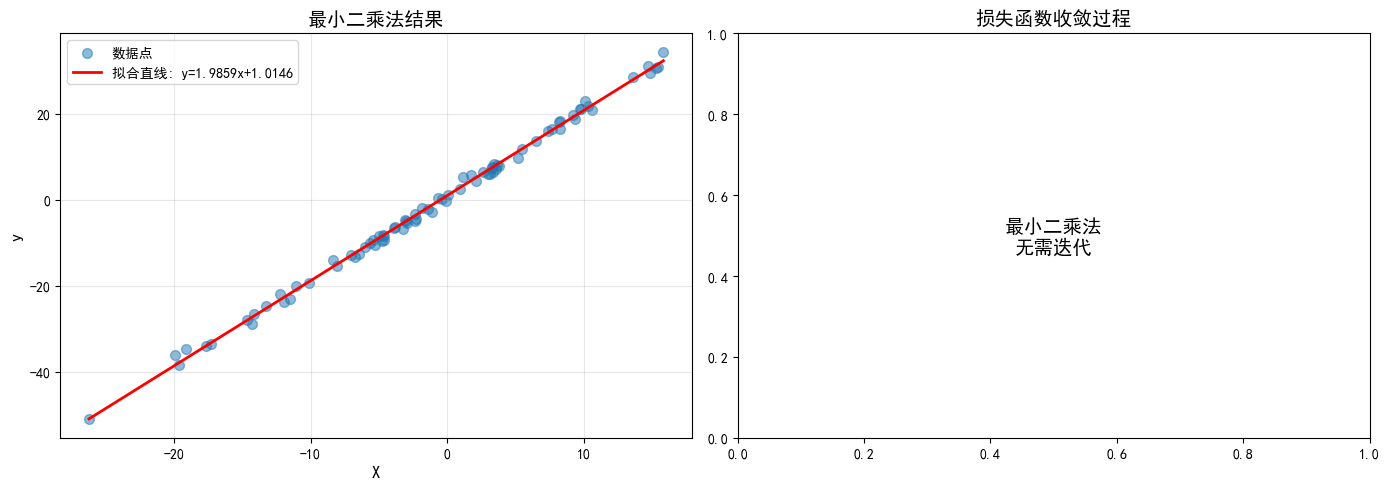


梯度下降结果可视化：


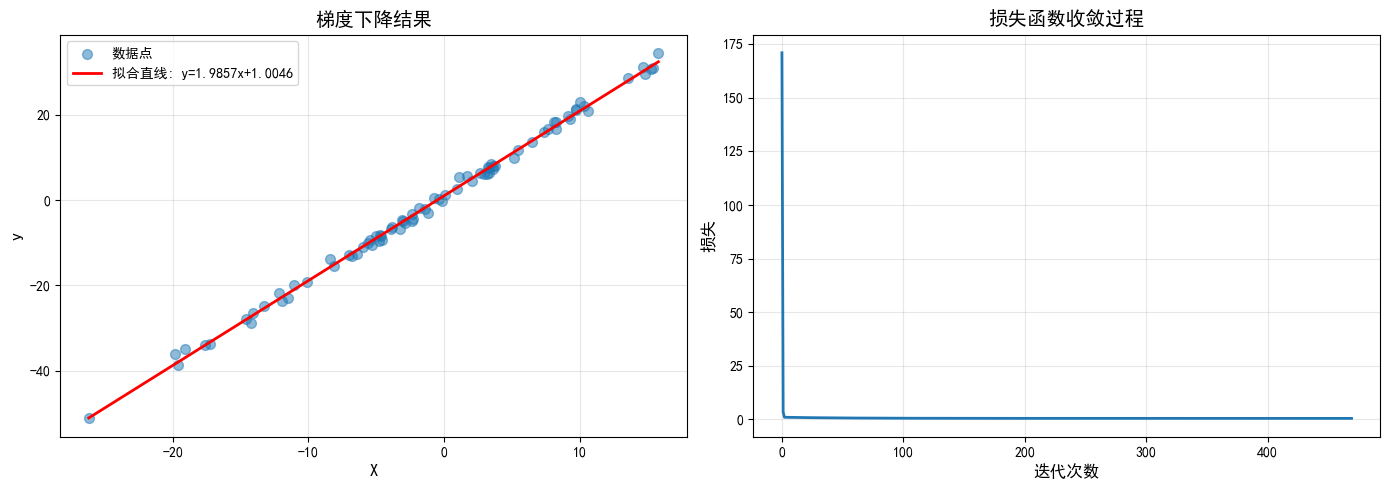

In [22]:
def visualize_results(X, y, model, title="线性回归结果"):
    """
    可视化线性回归结果
    
    参数:
    - X: 特征数据
    - y: 目标值
    - model: 训练好的模型
    - title: 图表标题
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：数据点和拟合直线
    axes[0].scatter(X, y, alpha=0.5, label='数据点', s=50)
    X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = model.predict(X_line)
    axes[0].plot(X_line, y_line, 'r-', linewidth=2, 
                 label=f'拟合直线: y={model.w[0]:.4f}x+{model.b:.4f}')
    axes[0].set_xlabel('X', fontsize=12)
    axes[0].set_ylabel('y', fontsize=12)
    axes[0].set_title(title, fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # 右图：损失函数收敛过程（仅梯度下降）
    if model.method == 'gradient_descent' and len(model.cost_history) > 0:
        axes[1].plot(model.cost_history, linewidth=2)
        axes[1].set_xlabel('迭代次数', fontsize=12)
        axes[1].set_ylabel('损失', fontsize=12)
        axes[1].set_title('损失函数收敛过程', fontsize=14)
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, '最小二乘法\n无需迭代', 
                     ha='center', va='center', fontsize=14)
        axes[1].set_title('损失函数收敛过程', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# 可视化最小二乘法的结果
print("\n最小二乘法结果可视化：")
visualize_results(X_train, y_train, model_ls, "最小二乘法结果")

# 可视化梯度下降的结果
print("\n梯度下降结果可视化：")
visualize_results(X_train, y_train, model_gd, "梯度下降结果")


## 8. 方法对比

让我们对比两种方法的性能。


方法对比
方法                   MSE             R²             
--------------------------------------------------
最小二乘法                0.8728          0.9964         
梯度下降                 0.8722          0.9964         


C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\877036675.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(X_line, y_line_ls, 'r-', linewidth=2, label='最小二乘法', linestyle='--')
C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\877036675.py:46: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


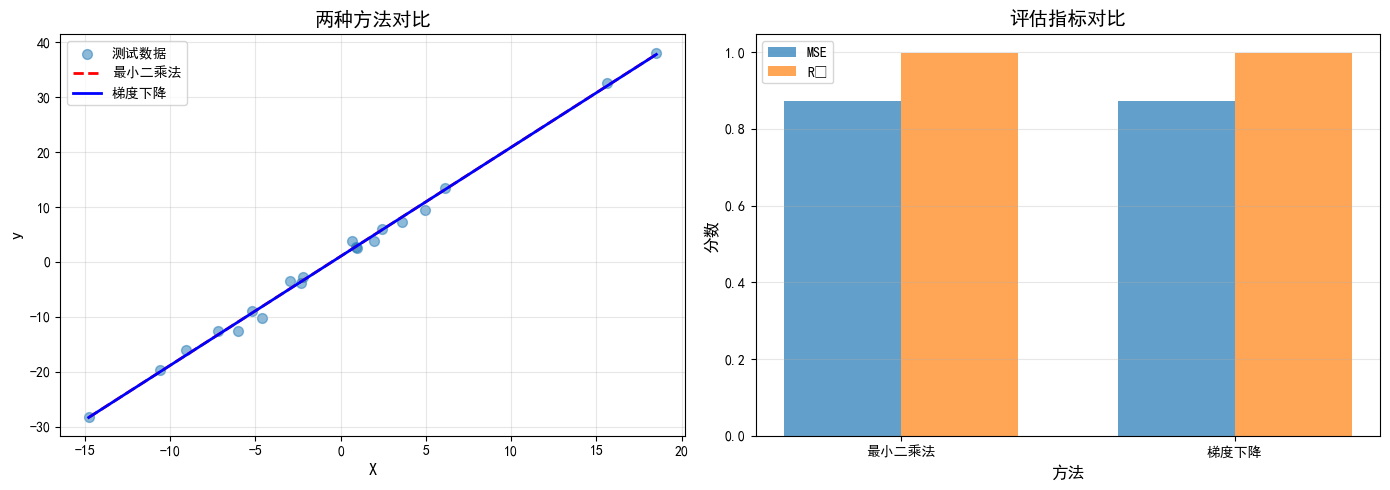

In [23]:
print("=" * 60)
print("方法对比")
print("=" * 60)
print(f"{'方法':<20} {'MSE':<15} {'R²':<15}")
print("-" * 50)
print(f"{'最小二乘法':<20} {mse_ls:<15.4f} {r2_ls:<15.4f}")
print(f"{'梯度下降':<20} {mse_gd:<15.4f} {r2_gd:<15.4f}")

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：两种方法的拟合直线对比
axes[0].scatter(X_test, y_test, alpha=0.5, label='测试数据', s=50)
X_line = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)

y_line_ls = model_ls.predict(X_line)
axes[0].plot(X_line, y_line_ls, 'r-', linewidth=2, label='最小二乘法', linestyle='--')

y_line_gd = model_gd.predict(X_line)
axes[0].plot(X_line, y_line_gd, 'b-', linewidth=2, label='梯度下降')

axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('两种方法对比', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 右图：评估指标对比
methods = ['最小二乘法', '梯度下降']
mse_values = [mse_ls, mse_gd]
r2_values = [r2_ls, r2_gd]

x = np.arange(len(methods))
width = 0.35

axes[1].bar(x - width/2, mse_values, width, label='MSE', alpha=0.7)
axes[1].bar(x + width/2, r2_values, width, label='R²', alpha=0.7)
axes[1].set_xlabel('方法', fontsize=12)
axes[1].set_ylabel('分数', fontsize=12)
axes[1].set_title('评估指标对比', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods)
axes[1].legend(fontsize=10)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 9. 参数实验

### 实验1：修改学习率

尝试不同的学习率，观察梯度下降的收敛情况。

**提示**：学习率太小会导致收敛慢，学习率太大会导致不收敛或震荡。


在第 470 次迭代后收敛


C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\2724583318.py:82: RuntimeWarning: overflow encountered in square
  cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
d:\Anaconda\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\2724583318.py:96: RuntimeWarning: invalid value encountered in scalar subtract
  if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tol:
C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\2724583318.py:78: RuntimeWarning: overflow encountered in matmul
  y_pred = X @ self.w + self.b  # 矩阵乘法：X @ w 表示 X * w
C:\Users\Upsin\AppData\Local\Temp\ipykernel_51064\2724583318.py:87: RuntimeWarning: overflow encountered in matmul
  dw = (1 / m) * X.T @ (y_pred - y)
d:\Anaconda\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, 

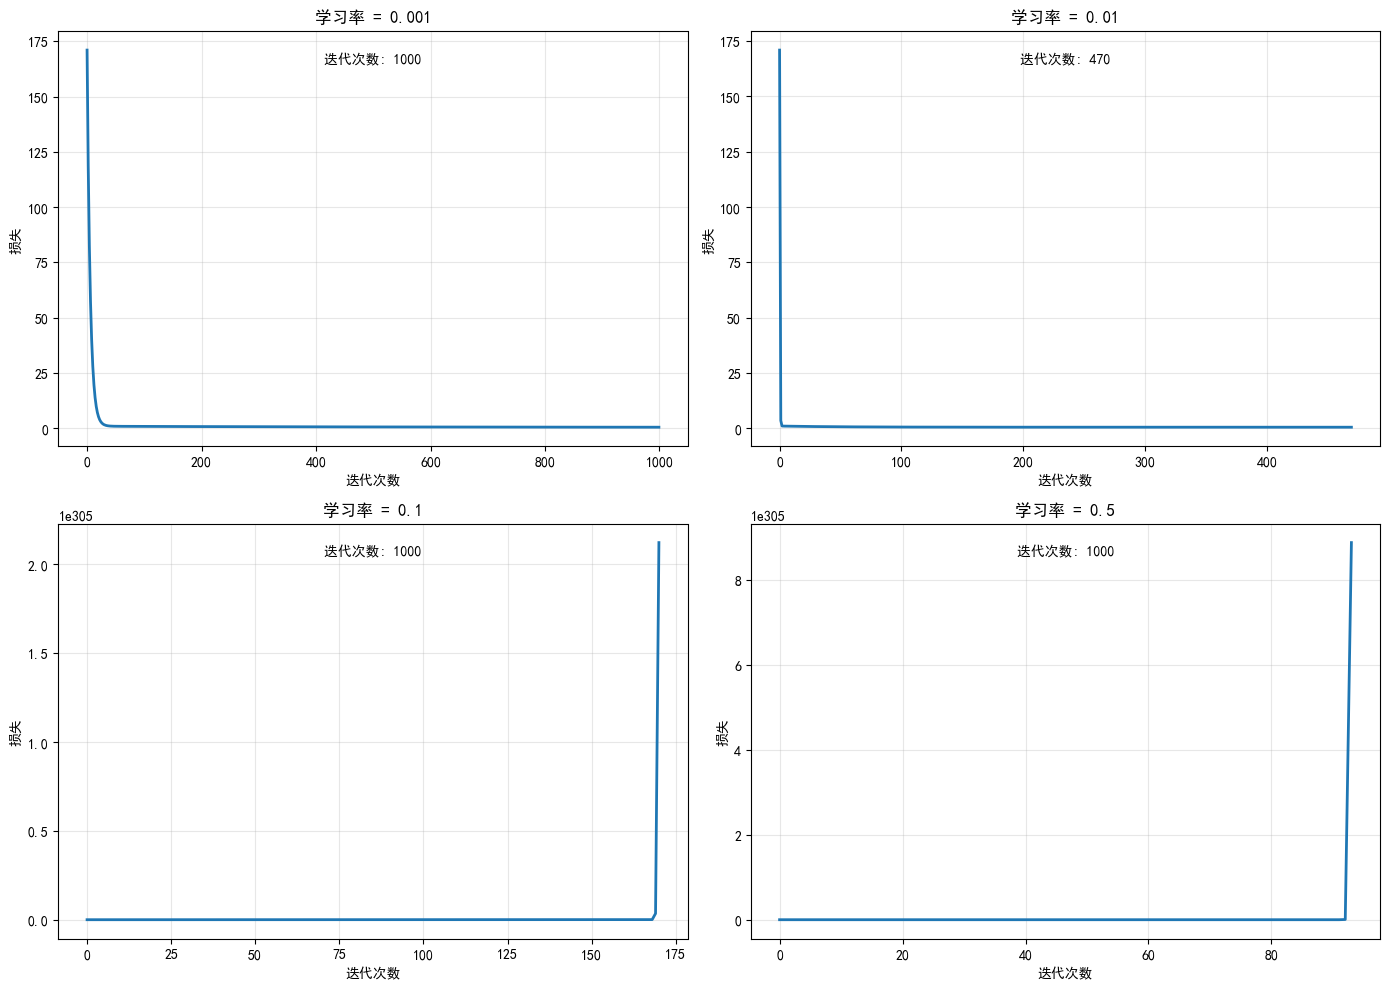


思考问题：
1. 学习率对收敛速度有什么影响？
2. 学习率太大或太小会出现什么问题？
3. 如何选择合适的学习率？


In [24]:
# 实验不同的学习率
learning_rates = [0.001, 0.01, 0.1, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, lr in enumerate(learning_rates):
    model = LinearRegression(
        method='gradient_descent',
        learning_rate=lr,
        max_iter=1000,
        tol=1e-6
    )
    model.fit(X_train, y_train)
    
    axes[i].plot(model.cost_history, linewidth=2)
    axes[i].set_xlabel('迭代次数', fontsize=10)
    axes[i].set_ylabel('损失', fontsize=10)
    axes[i].set_title(f'学习率 = {lr}', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].text(0.5, 0.95, f'迭代次数: {len(model.cost_history)}', 
                 transform=axes[i].transAxes, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()

print("\n思考问题：")
print("1. 学习率对收敛速度有什么影响？")
print("2. 学习率太大或太小会出现什么问题？")
print("3. 如何选择合适的学习率？")


## 10. 总结与思考

### 关键知识点总结

1. **线性回归原理**：
   - 找到一条直线（或超平面）来拟合数据
   - 目标是最小化预测值与真实值之间的误差

2. **两种优化方法**：
   - **最小二乘法**：解析解，计算快，但需要计算矩阵逆
   - **梯度下降**：数值解，适用于大规模数据，但需要迭代

3. **评估指标**：
   - **MSE（均方误差）**：衡量预测误差的大小
   - **R²（决定系数）**：衡量模型解释的方差比例

### 思考问题

1. **什么时候用最小二乘法？什么时候用梯度下降？**
   - 最小二乘法：数据量不大，特征数不多时
   - 梯度下降：大规模数据，特征数很多时

2. **如何选择学习率？**
   - 太小：收敛慢
   - 太大：可能不收敛或震荡
   - 建议：从0.01开始，根据收敛情况调整

3. **如何判断模型是否过拟合？**
   - 训练集误差很小，但测试集误差很大
   - 可以使用交叉验证来评估

### 下一步学习

- 学习正则化（L1、L2）防止过拟合
- 学习多项式回归处理非线性关系
- 学习多特征线性回归
- 学习使用scikit-learn实现线性回归

---

**恭喜！你已经完成了从零实现线性回归的学习！** 🎉
